In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepfake-detection-challenge/sample_submission.csv
/kaggle/input/deepfake-detection-challenge/test_videos/qooxnxqqjb.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/hierggamuo.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ocgdbrgmtq.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/icbsahlivv.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/prhmixykhr.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ihglzxzroo.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/yarpxfqejd.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/orixbcfvdz.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/qxyrtwozyw.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/hqzwudvhih.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ghnpsltzyn.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ziipxxchai.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/fddmkqjwsh.mp4
/kaggle/input/deepfake-de

In [2]:
!pip install mtcnn tensorflow opencv-python pandas numpy scikit-learn


     |████████████████████████████████| 2.3MB 10.1MB/s eta 0:00:01


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from mtcnn import MTCNN
from tqdm import tqdm

# Initialize MTCNN face detector
detector = MTCNN()

# Paths and setup
video_folder = '../input/deepfake-detection-challenge/train_sample_videos/'
metadata_path = '../input/deepfake-detection-challenge/train_sample_videos/metadata.json'
output_real_folder = './extracted_faces/real/'
output_fake_folder = './extracted_faces/fake/'

# Create directories if they don't exist
os.makedirs(output_real_folder, exist_ok=True)
os.makedirs(output_fake_folder, exist_ok=True)

# Load metadata
train_sample_metadata = pd.read_json(metadata_path).T

# Function to detect and save faces from video frames
def extract_faces(video_path, output_folder, label, video_name):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(frame_count // 5, 1)  # Ensure at least 5 frames are captured at regular intervals

    captured_frames = 0
    for i in range(0, frame_count, frame_interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret or captured_frames >= 5:
            break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        faces = detector.detect_faces(frame_rgb)
        
        for j, face in enumerate(faces):
            x, y, width, height = face['box']
            face_img = frame_rgb[y:y+height, x:x+width]
            face_img = cv2.resize(face_img, (224, 224))  # Resize face to 224x224
            
            # Save the face image
            face_filename = f"{label}_{video_name}_{i}_{j}.jpg"
            face_filepath = os.path.join(output_folder, face_filename)
            cv2.imwrite(face_filepath, cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR))
        
        captured_frames += 1
    
    cap.release()

# Extract faces from videos
for video_name, row in tqdm(train_sample_metadata.iterrows(), total=train_sample_metadata.shape[0]):
    video_path = os.path.join(video_folder, video_name)
    label = row['label']
    output_folder = output_real_folder if label == 'REAL' else output_fake_folder
    extract_faces(video_path, output_folder, label, video_name)


 32%|███▏      | 126/400 [11:21<23:12,  5.08s/it]

KeyboardInterrupt: 

In [5]:
!pip install -q git+https://github.com/tensorflow/examples.git


In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from glob import glob

# Load and preprocess the dataset
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1
    return image

def load_image_train(image_file):
    image = load_image(image_file)
    return image

def load_image_test(image_file):
    image = load_image(image_file)
    return image

# Define the dataset
def get_dataset(image_dir):
    image_files = glob(os.path.join(image_dir, '*'))
    dataset = tf.data.Dataset.from_tensor_slices(image_files)
    dataset = dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_files))
    dataset = dataset.batch(1)
    return dataset

# Directories for real and fake faces
real_image_dir = './extracted_faces/real/'
fake_image_dir = './extracted_faces/fake/'

real_dataset = get_dataset(real_image_dir)
fake_dataset = get_dataset(fake_image_dir)

# Define the CycleGAN model
OUTPUT_CHANNELS = 3

def unet_generator(output_channels, norm_type='batchnorm'):
    initializer = tf.random_normal_initializer(0., 0.02)

    down_stack = [
        pix2pix.downsample(64, 4, apply_norm=False),  # (bs, 128, 128, 64)
        pix2pix.downsample(128, 4),  # (bs, 64, 64, 128)
        pix2pix.downsample(256, 4),  # (bs, 32, 32, 256)
        pix2pix.downsample(512, 4),  # (bs, 16, 16, 512)
        pix2pix.downsample(512, 4),  # (bs, 8, 8, 512)
        pix2pix.downsample(512, 4),  # (bs, 4, 4, 512)
        pix2pix.downsample(512, 4),  # (bs, 2, 2, 512)
        pix2pix.downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        pix2pix.upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        pix2pix.upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        pix2pix.upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        pix2pix.upsample(512, 4),  # (bs, 16, 16, 1024)
        pix2pix.upsample(256, 4),  # (bs, 32, 32, 512)
        pix2pix.upsample(128, 4),  # (bs, 64, 64, 256)
        pix2pix.upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    last = tf.keras.layers.Conv2DTranspose(output_channels, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, output_channels)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

# Loss functions
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

# Training Step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F translates Y -> X
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generators and discriminators
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                          generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                              discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                              discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                              generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                              generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                  discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  discriminator_y.trainable_variables))

# Training Loop
EPOCHS = 40

for epoch in range(EPOCHS):
    start = time.time()

    for image_x, image_y in tf.data.Dataset.zip((real_dataset, fake_dataset)):
        train_step(image_x, image_y)

    clear_output(wait=True)
    print(f'Time taken for epoch {epoch + 1} is {time.time() - start} sec\n')

    if (epoch + 1) % 5 == 0:
        ckpt_manager.save()

# Save the model
generator_g.save('generator_g.h5')
generator_f.save('generator_f.h5')


Time taken for epoch 19 is 127.74234127998352 sec



Epoch 7, Time taken: 239.1686613559723 sec
Generator G Loss: 1.7686588764190674, Generator F Loss: 1.7731895446777344
Discriminator X Loss: 0.695159912109375, Discriminator Y Loss: 0.6952673196792603


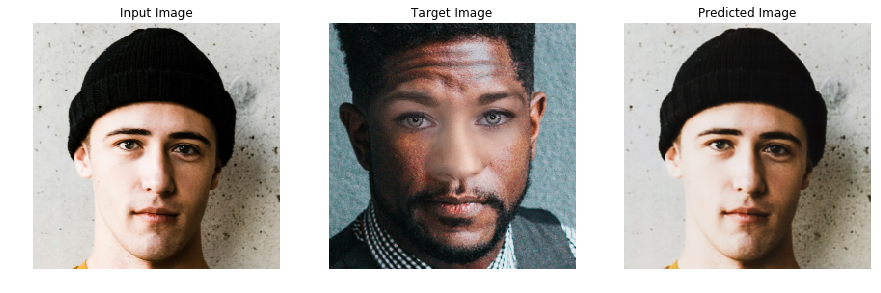

KeyboardInterrupt: 

In [8]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from glob import glob

# Load and preprocess the dataset
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1
    return image

def load_image_train(image_file):
    image = load_image(image_file)
    return image

def load_image_test(image_file):
    image = load_image(image_file)
    return image

# Define the dataset
def get_dataset(image_dir):
    image_files = glob(os.path.join(image_dir, '*'))
    dataset = tf.data.Dataset.from_tensor_slices(image_files)
    dataset = dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_files))
    dataset = dataset.batch(1)
    return dataset

# Directories for real and fake faces
real_image_dir = '/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_real'
fake_image_dir = '/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake'

real_dataset = get_dataset(real_image_dir)
fake_dataset = get_dataset(fake_image_dir)

# Define the CycleGAN model
OUTPUT_CHANNELS = 3

def unet_generator(output_channels, norm_type='batchnorm'):
    initializer = tf.random_normal_initializer(0., 0.02)

    down_stack = [
        pix2pix.downsample(64, 4, apply_norm=False),  # (bs, 128, 128, 64)
        pix2pix.downsample(128, 4),  # (bs, 64, 64, 128)
        pix2pix.downsample(256, 4),  # (bs, 32, 32, 256)
        pix2pix.downsample(512, 4),  # (bs, 16, 16, 512)
        pix2pix.downsample(512, 4),  # (bs, 8, 8, 512)
        pix2pix.downsample(512, 4),  # (bs, 4, 4, 512)
        pix2pix.downsample(512, 4),  # (bs, 2, 2, 512)
        pix2pix.downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        pix2pix.upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        pix2pix.upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        pix2pix.upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        pix2pix.upsample(512, 4),  # (bs, 16, 16, 1024)
        pix2pix.upsample(256, 4),  # (bs, 32, 32, 512)
        pix2pix.upsample(128, 4),  # (bs, 64, 64, 256)
        pix2pix.upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    last = tf.keras.layers.Conv2DTranspose(output_channels, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, output_channels)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

# Loss functions
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

# Function to generate and display images
def generate_images(model, test_input, tar, save=False, epoch=0):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Target Image', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5 + 0.5).numpy())
        plt.axis('off')
    
    if save:
        plt.savefig(f'epoch_{epoch}_result.png')
    plt.show()

# Training Step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F translates Y -> X
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generators and discriminators
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    
    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

# Training Loop
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    total_gen_g_loss = 0
    total_gen_f_loss = 0
    total_disc_x_loss = 0
    total_disc_y_loss = 0
    num_batches = 0

    for image_x, image_y in tf.data.Dataset.zip((real_dataset, fake_dataset)):
        gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
        total_gen_g_loss += gen_g_loss
        total_gen_f_loss += gen_f_loss
        total_disc_x_loss += disc_x_loss
        total_disc_y_loss += disc_y_loss
        num_batches += 1

    # Calculate the average loss for this epoch
    avg_gen_g_loss = total_gen_g_loss / num_batches
    avg_gen_f_loss = total_gen_f_loss / num_batches
    avg_disc_x_loss = total_disc_x_loss / num_batches
    avg_disc_y_loss = total_disc_y_loss / num_batches

    clear_output(wait=True)
    print(f'Epoch {epoch + 1}, Time taken: {time.time() - start} sec')
    print(f'Generator G Loss: {avg_gen_g_loss.numpy()}, Generator F Loss: {avg_gen_f_loss.numpy()}')
    print(f'Discriminator X Loss: {avg_disc_x_loss.numpy()}, Discriminator Y Loss: {avg_disc_y_loss.numpy()}')

    # Generate and display images after each epoch
    for example_real_image, example_fake_image in zip(real_dataset.take(1), fake_dataset.take(1)):
        generate_images(generator_g, example_real_image, example_fake_image, save=True, epoch=epoch + 1)

    if (epoch + 1) % 5 == 0:
        ckpt_manager.save()

# Save the model
generator_g.save('generator_g.h5')
generator_f.save('generator_f.h5')
